<h1>Introduction</h1>
<p>
The sinking of the titanic occurred on the night of 14<sup>th</sup> April, 1912. It was the largest passenger liner in service at the time and had an estimated 2224 people on board when she had struck an iceberg around 2340 hours. Within hours, the ship was underwater. The accident resulted in the deaths of more than 1,500 people. The disaster caused widespread outrage over the lack of lifeboats, lax regulations, and the unequal treatment of the three passenger classes during the evacuation. 
</p>
<h2>Objectives</h2>
<p>
To analyze the survivability rate based on the data provided and extrapolate other unexpected reasons for survival.
</p>

<h2>Data Wrangling</h2>

<h3>Data description</h3>
<div id="description">
(from https://www.kaggle.com/c/titanic)
    <p>
      <ul>
        <li>survival: Survival (0 = No; 1 = Yes)</li>
        <li>pclass: Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)</li>
        <li>name: Name</li>
        <li>sex: Sex</li>
        <li>age: Age</li>
        <li>sibsp: Number of Siblings/Spouses Aboard</li>
        <li>parch: Number of Parents/Children Aboard</li>
        <li>ticket: Ticket Number</li>
        <li>fare: Passenger Fare</li>
        <li>cabin: Cabin</li>
        <li>embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)</li>
      </ul>
    </p>

<h3>Special Notes:</h3>
    <p>
        <ul>
            <li>Pclass is a proxy for socio-economic status (SES) 1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower</li>
            <li>Age is in Years; Fractional if Age less than One (1) If the Age is Estimated, it is in the form xx.5</li>
        </ul>
    </p>
    <p>
    With respect to the family relation variables (i.e. sibsp and parch) some relations were ignored. The following are the definitions used for sibsp and parch.
    </p>
    <p>
        <ul>
            <li>Sibling: Brother, Sister, Stepbrother, or Stepsister of Passenger Aboard Titanic </li>
            <li>Spouse: Husband or Wife of Passenger Aboard Titanic (Mistresses and Fiances Ignored) </li>
            <li>Parent: Mother or Father of Passenger Aboard Titanic </li>
            <li>Child: Son, Daughter, Stepson, or Stepdaughter of Passenger Aboard Titanic </li>
        </ul>
    </p>
    <p>
    Other family relatives excluded from this study include cousins, nephews/nieces, aunts/uncles, and in-laws. Some children travelled only with a nanny, therefore parch=0 for them. As well, some travelled with very close friends or neighbors in a village, however, the definitions do not support such relations.
    </p>
</div>
<h2>Initial questions</h2>
<p>
    <ol>
        <li>What factors are positively related to survival?</li>
        <li>Are there other factors that could affect survival?</li>
    </ol>
</p>

In [1]:
# Importing numpy, pandas for sorting data into matrices and matplot and seaborn libraries for visualization; 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

# present charts inline 
%pylab inline

# setting style and background for all graphs
sns.set(color_codes=True)
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Helper functions:

# takes in target dataframe and plots correlation as heatmap
def plot_correlation_map( df ):
    corr = df.corr() # describes data in dataframe and stored in variable 
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True ) # color of tiles
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 } 
    )

# plots histogram of given dataframe; cat: data used for x-axis and target: data used for y-axis.
# row and col can take arguments and display individual graphs based on argument vertically or horizontally respectively.
def plot_categories( df, cat, target, **kwargs ):
    row = kwargs.get( 'row', None )
    col = kwargs.get( 'col', None )
    facet = sns.FacetGrid( df, row = row, col = col) # sets up grid
    facet.map( sns.barplot, cat, target) # displays bar graph
    facet.add_legend()

# plots histograms that displays the count of variable 1, with respect to the other variables and dataframe of interest
# all variables need to be strings
def graph_count_plotter (df, var1, var2, var3, **kwargs):
    return sns.factorplot( \
    var1, col=var2, hue=var3, data=df, kind='count', size=7, aspect=.8)

# plots kdeplot based on dataframe and variables. Different way of displaying data.
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True ) # displays continuous plot 
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

In [3]:
# loading titanic data as pandas dataframe
titanic_df = pd.read_csv('titanic_data.csv')

# data preview of full dataset
titanic_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<b>Note:</b> Some values for Age are NaN, while ticket and cabin values are alphanumeric and also missing values with NaN. 


<h1>Data Cleaning</h1>

In [4]:
# determine number of missing values in cleaned data set
total_null = titanic_df.isnull().sum()
print total_null

# determining number of missing age entries for males and females

age_nans = pd.isnull(titanic_df['Age'])

print titanic_df[age_nans].head()

missing_age_female = titanic_df[age_nans]['Sex'] == 'female'
missing_age_male = titanic_df[age_nans]['Sex'] == 'male'

print 'Number for females and males with age missing are {} and {} respectively'.format(
    missing_age_female.sum(),missing_age_male.sum())


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
    PassengerId  Survived  Pclass                           Name     Sex  Age  \
5             6         0       3               Moran, Mr. James    male  NaN   
17           18         1       2   Williams, Mr. Charles Eugene    male  NaN   
19           20         1       3        Masselmani, Mrs. Fatima  female  NaN   
26           27         0       3        Emir, Mr. Farred Chehab    male  NaN   
28           29         1       3  O'Dwyer, Miss. Ellen "Nellie"  female  NaN   

    SibSp  Parch  Ticket     Fare Cabin Embarked  
5       0      0  330877   8.4583   NaN        Q  
17      0      0  244373  13.0000   NaN        S  
19      0      0    2649   7.2250   NaN        C  
26      0      0    2631   7.2250   NaN        C  
28      0      0 

<p>177 null age items were detected in the given dataset, which accounts for ~20% of the total number of passengers recorded in this data. It will not affect the graphing and summation operations on the data as it is treated as a zero(0) value, but it needs to be considered while reviewing descriptive stats like average (mean) age. </p>
<p> 
<b>Note:</b>
<br>
Number of female passengers whose age is missing - <b>124</b>
<br>
Number of male passengers whose age is missing - <b>53</b>
</p>

<p>The null values were replaced with median of the age rather than the mean or zero so that during the calculation of the mean so as to avoid any skewed values. 
</p>

In [5]:
# Cleaning data: Removing items that do not contribute to survival analysis

# Dropping information that does not pertain to current questions
# cleaned data will contain int variables and are chosen to make it easier to describe data.

titanic_cleaned = titanic_df.drop(['Cabin','Name','Ticket','PassengerId','Embarked'], axis=1)

# replacing Nans
median_age = titanic_cleaned['Age'].median()

print median_age

titanic_without_nan = titanic_cleaned.fillna(median_age)

age_nans = pd.isnull(titanic_without_nan['Age'])
print titanic_without_nan[age_nans].head() # checking if data-frame has any null values.


28.0
Empty DataFrame
Columns: [Survived, Pclass, Sex, Age, SibSp, Parch, Fare]
Index: []


In [6]:
titanic_without_nan.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.361582,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.019697,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


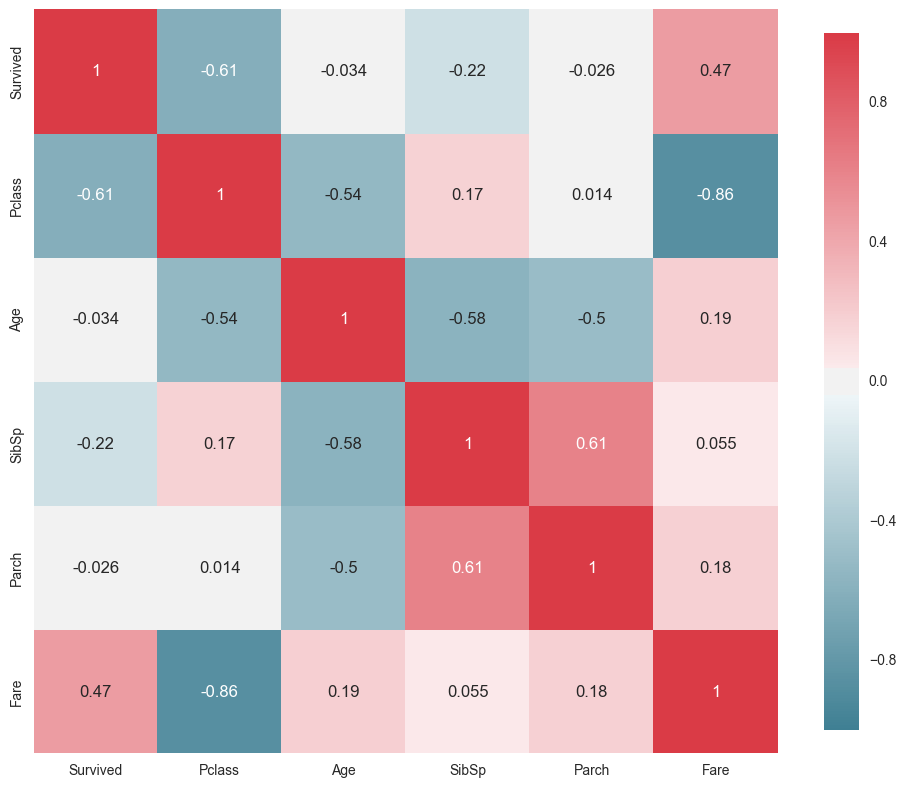

In [7]:
# correlation heatmap
correlated_variables = titanic_without_nan.corr()
plot_correlation_map(correlated_variables)

# heatmap shows important variables for consideration. 
# based on plot, positive correlation between survival and fare, 
# and negative correlation between survival and class. 

Let's investigate the correlation between the several variables presented in the dataset. The heatmap in the cell above shows positive correlation between survivability and age, whereas there is a negative correlation between class and survival. Initial observations suggest that we should investigate the following :
<h2>Questions</h2>
<p>
Q1. Are there any biases based on gender and class in the survivability of the passenger ? <br>
Q2. Does a family or individual have a higher chance to survive this catastrophe? <br>
Q3. Was there increased survivability based on age? 
</p>
<p>
Other questions that could be derived from this analysis: <br>
Q4. Was there any relation between the survivors and location from where the travellers originated (embarked)? <br>
Q5. Is it possible a certain section of the ship was able to survive the accident better than others? <br>
</p>

In [8]:
# prints survival percentage values based on gender and class. It takes in dataframe(df) and 2 variables that defines
# how the df will be grouped and will perform calculations appropriately.

def percent_survivors( df , var1 , var2 ):
    n = 0
    sex = ['male','female']
    pclass = [1,2,3]
    df_survived = df[df['Survived']==True]
    for item in pclass:
        for gender in sex:
            grouped_class_gender = df.groupby([var1,var2]).size()[item,gender].astype('float') 
            survived_class_gender = df_survived.groupby([var1,var2]).size()[item,gender].astype('float')
            survivors_by_gender = ((survived_class_gender/grouped_class_gender) * 100).round(2)
            print "Survivors of {}: {} and {}: {} are {}%".format(var1,item,var2,gender,survivors_by_gender)
percent_survivors (titanic_without_nan,'Pclass','Sex')
# print percent_survivors(titanic_without_nan, 1 , 'male')

Survivors of Pclass: 1 and Sex: male are 36.89%
Survivors of Pclass: 1 and Sex: female are 96.81%
Survivors of Pclass: 2 and Sex: male are 15.74%
Survivors of Pclass: 2 and Sex: female are 92.11%
Survivors of Pclass: 3 and Sex: male are 13.54%
Survivors of Pclass: 3 and Sex: female are 50.0%


Total number of survivors based on class and sex: 
Pclass  Sex     Survived
1       female  0             3.0
                1            91.0
        male    0            77.0
                1            45.0
2       female  0             6.0
                1            70.0
        male    0            91.0
                1            17.0
3       female  0            72.0
                1            72.0
        male    0           300.0
                1            47.0
dtype: float64


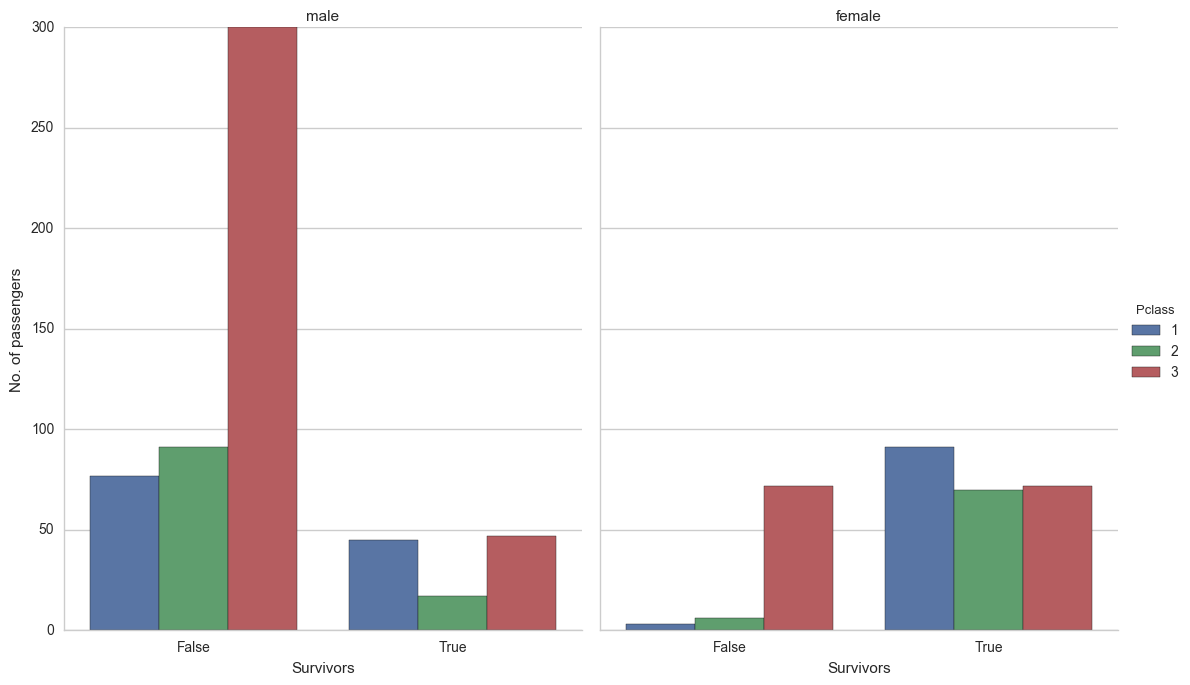

In [9]:
survived_class_gender = titanic_without_nan.groupby(['Pclass','Sex','Survived']).size().astype('float')

print "Total number of survivors based on class and sex: \n{}".format(survived_class_gender)

# Investiage total number of survivors based on class

g = graph_count_plotter(titanic_without_nan,'Survived','Sex','Pclass')
# survival_count_sex_class = sns.factorplot( \
#     'Survived', col='Sex', hue='Pclass', data=titanic_without_nan, kind='count', size=7, aspect=.8)

(g.set_axis_labels('Survivors','No. of passengers')
    .set_xticklabels(['False','True'])
    .set_titles('{col_name}'))


<p>Based on the raw numbers it would appear as though passengers in Class 3 category had a similar survival rate as those from Class 1 category with 119 and 136 passengers surviving respectively. However, if we look closely at the percentages of the overall passengers per class and the total numbers across each class, it can be assumed that a passenger from Class 1 is about <b>2.5x</b> times more likely to survive than a passenger in Class 3.</p>

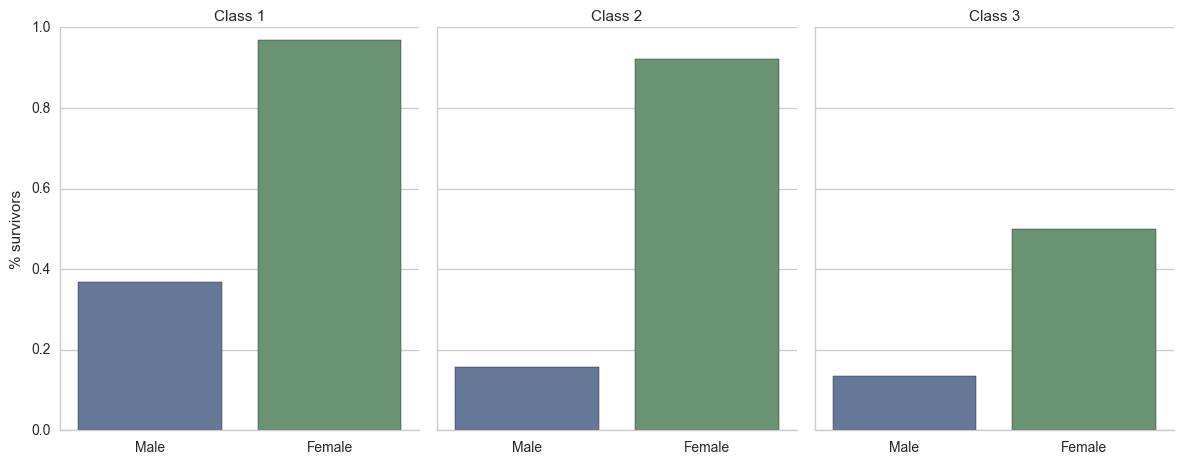

In [10]:
# Percentage - number of survivors by gender and class 
# Comparison of survivors by sex and class

# Histogram to display survivors grouped by sex and class
variable_compare = sns.factorplot(x='Sex', y='Survived', col='Pclass', data=titanic_without_nan, 
                   saturation=.5, kind="bar", ci=None, size=5, aspect=.8)
# adding labels
(variable_compare.set_axis_labels('', '% survivors')
     .set_xticklabels(['Male', 'Female'])
     .set_titles('Class {col_name}'))


The graphs displayed above indicate that there was definitely higher chance of survival if you were <b>female</b> rather than male and an even higher chance of survival if you were part of the upper echelons of society. 
The graphs shown below confirm this analysis and indicate that there were more female survivors than male survivors overall, regardless of class. 

Next Question
<p><b>Is there an increased chance of survival based on age?</b>
</p>

In [11]:
# Analysis based on Age:

# How about infant survival?

infants = titanic_df[titanic_df['Age'] < 1]
# print infants.head()

# death count of children age < 1?

non_survivors_infants = infants[infants['Survived'] == False]['Survived'].count()
print "Number of non survivors less than a year old: {}".format(non_survivors_infants)

# Number of survivors whose age is >40?

old = titanic_without_nan[titanic_without_nan['Age'] > 40]
# print old.count()
non_survivors_seniors = old[old['Survived'] == False]['Survived'].count()
print "Number of non survivors over 40: {}".format(non_survivors_seniors)


Number of non survivors less than a year old: 0
Number of non survivors over 40: 95


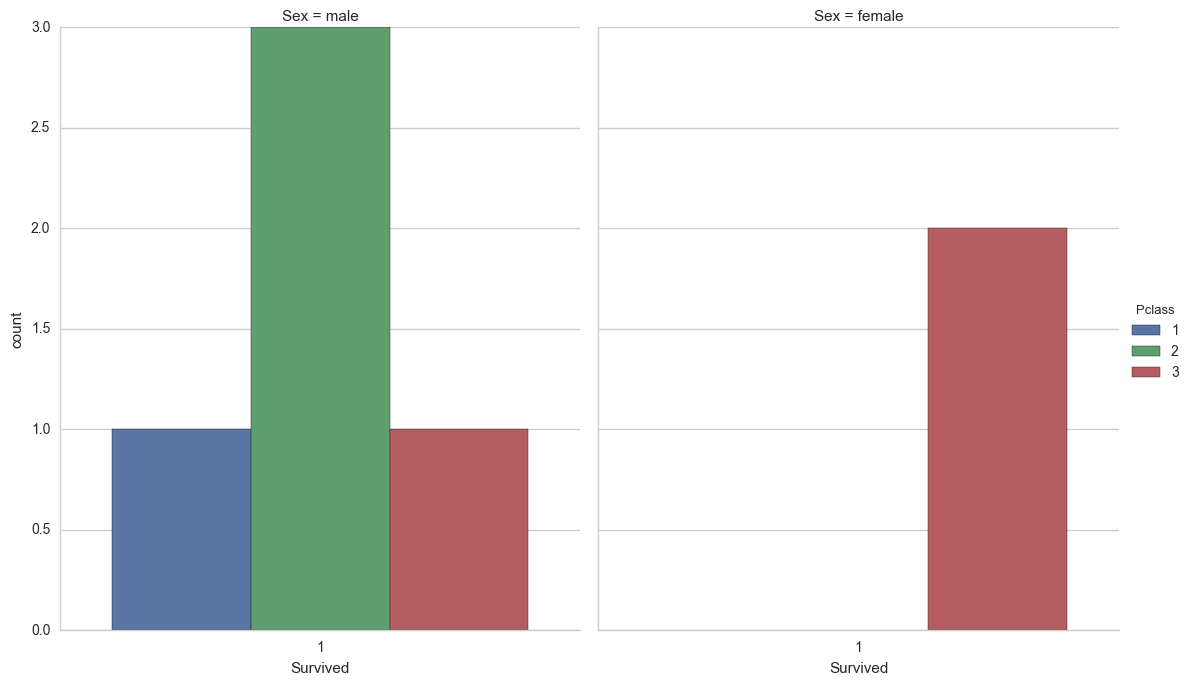

In [12]:
graph_count_plotter(infants,'Survived','Sex','Pclass')
# sns.factorplot('Survived', col='Sex', hue='Pclass', data=infants, kind='count', size=5, aspect=.8)

In [13]:
# Taking a look at some survival rates for babies
max_age_survived = titanic_without_nan[titanic_without_nan['Survived'] == True]['Age'].min()
min_age_dead = titanic_without_nan[titanic_without_nan['Survived'] == False]['Age'].min()
max_age_survived = titanic_without_nan[titanic_without_nan['Survived'] == True]['Age'].max()
max_age_dead = titanic_without_nan[titanic_without_nan['Survived'] == False]['Age'].max()

print 'Youngest to survive: {} \nYoungest to die: {} \nOldest to survive: {} \nOldest to die: {}'.format(
max_age_survived, min_age_dead, max_age_survived, max_age_dead)

Youngest to survive: 80.0 
Youngest to die: 1.0 
Oldest to survive: 80.0 
Oldest to die: 74.0


<p>
This information gives us information about the age of survivors and non-survivors. There were not any reservations for the elderly or children beyond the age of 1. In the previous cell, it showed that there were children under the age of 1 that did survive the calamity. These survivors were from various classes, and in this case, were not higher in the 1st class when compared to survivors in other age groups. 
</p>

Total number of survivors 342 
Total number of non survivors 549 
Mean age of survivors 28.0 
Mean age of non survivors 30.0 
Oldest to survive 80.0 
Oldest that didn't make it 74.0


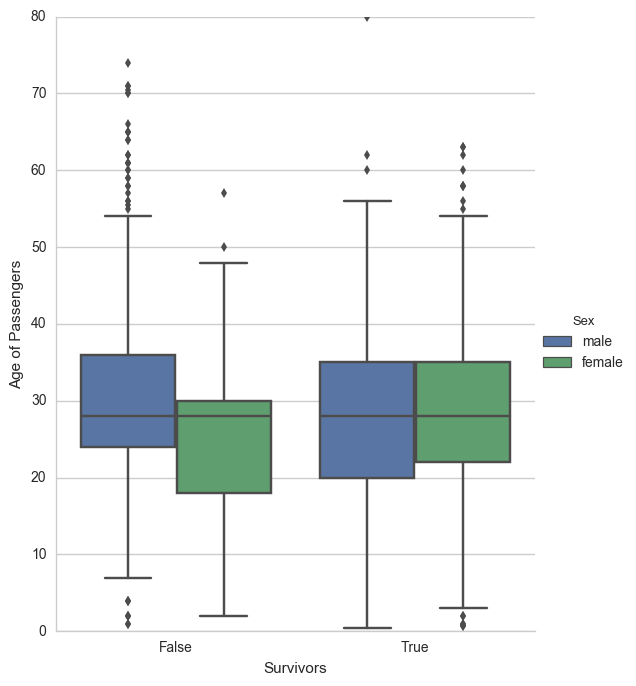

In [14]:
# Find total count of survivors and non-survivors
survived_passengers = titanic_without_nan[titanic_without_nan['Survived'] == True]['Survived'].count()
lost_souls = titanic_without_nan[titanic_without_nan['Survived'] == False]['Survived'].count()

# Find average of survivors and those who didn't
shipwreck_survivors = titanic_without_nan[titanic_without_nan['Survived'] == True]['Age'].mean()
mean_age_died = titanic_without_nan[titanic_without_nan['Survived'] == False]['Age'].mean()

# Display a few raw totals
print "Total number of survivors {} \n\
Total number of non survivors {} \n\
Mean age of survivors {} \n\
Mean age of non survivors {} \n\
Oldest to survive {} \n\
Oldest that didn't make it {}" \
.format(survived_passengers, lost_souls, np.round(shipwreck_survivors), 
        np.round(mean_age_died), max_age_survived, max_age_dead)

# Graph - Age of passengers across sex of those who survived
age_factorplot = sns.factorplot(x="Survived", y="Age", hue='Sex', data=titanic_without_nan, kind="box", size=7, aspect=.8)

# Fix up the labels
(age_factorplot.set_axis_labels('Survivors', 'Age of Passengers')
    .set_titles('Survival based on age of passengers')
    .set_xticklabels(["False", "True"])
)

As you denoted in the graph above, there were no advantages for seniority or if you were an infant. 

Next: <br> Did <b>women with children</b> have a better survival rate vs women <b>without</b> children (adults 18+)?

Category  Survived
Child     0            52
          1            61
Man       0           433
          1            86
Woman     0            64
          1           195
dtype: int64


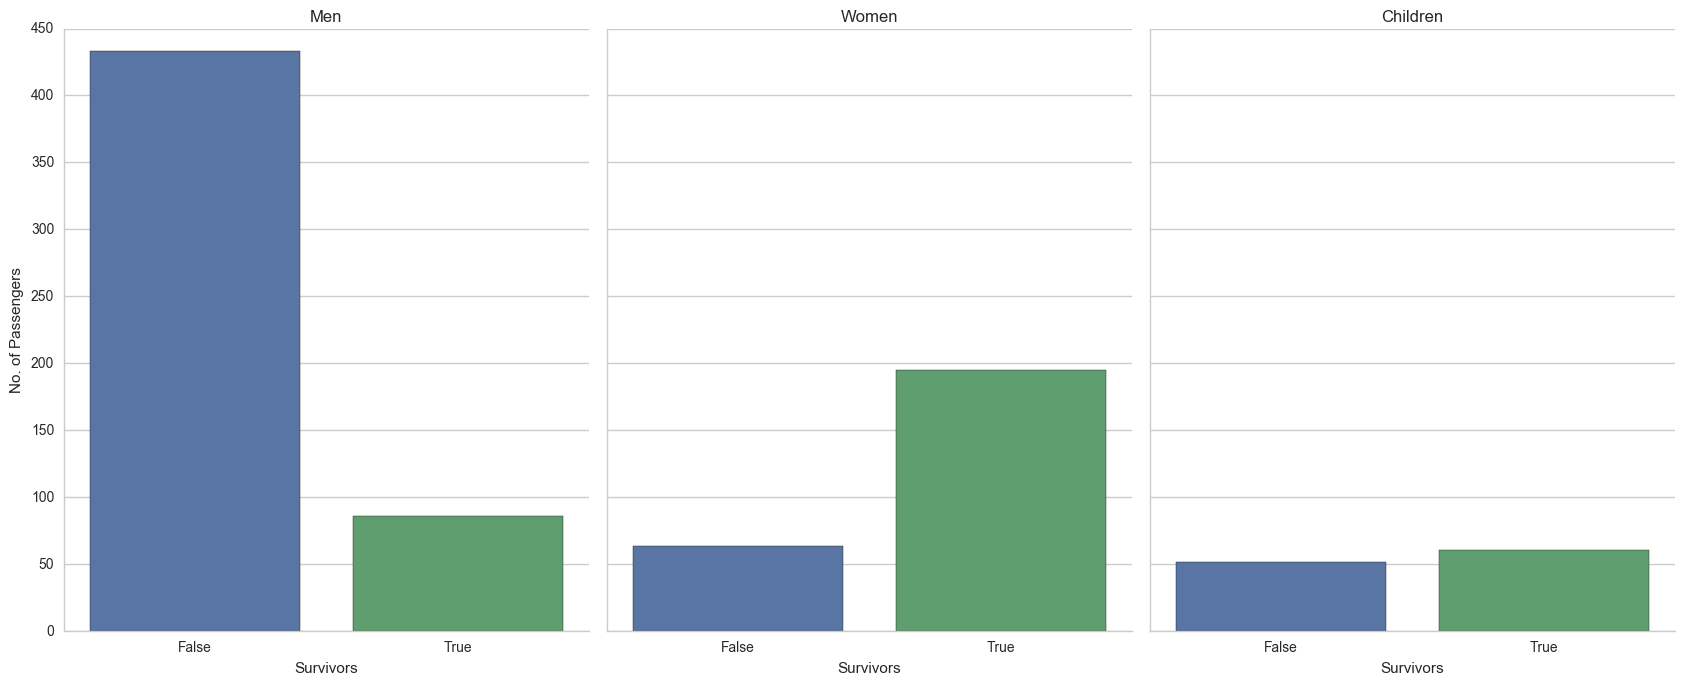

In [15]:
# Create Cateogry column and categorize people
titanic_without_nan.loc[
    ( (titanic_without_nan['Sex'] == 'female') & 
    (titanic_without_nan['Age'] >= 18) ),
    'Category'] = 'Woman'

titanic_without_nan.loc[
    ( (titanic_without_nan['Sex'] == 'male') & 
    (titanic_without_nan['Age'] >= 18) ),
    'Category'] = 'Man'

titanic_without_nan.loc[
    (titanic_without_nan['Age'] < 18),
    'Category'] = 'Child'

# Get the totals grouped by Men, Women and Children, and by survival
print titanic_without_nan.groupby(['Category','Survived']).size()

# Graph - Compare survival count between Men, Women and Children
g = sns.factorplot('Survived', col='Category', data=titanic_without_nan, kind='count', size=7, aspect=.8)

# Fix up the labels
(g.set_axis_labels('Survivors', 'No. of Passengers')
    .set_xticklabels(['False', 'True'])
)

titles = ['Men', 'Women', 'Children']
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)

<p>
The data and the graphs suggests that perhaps . It's a bit surprising that more children didn't survive but this could possibly be attributed to the mis-representation of what age is considered as the cut off for adults - i.e. if in the 1900's someone 15-17 were considered adults, they would not have been "saved" under the "women and children first" idea and would be made to fend for themselves. That would in turn, change the outcome of the above data and possible increase the number of children who survived.</p>

In [16]:
# Determine number of woman that are not parents

woman_parents = titanic_without_nan.loc[
    (titanic_without_nan['Category'] == 'Woman') &
    (titanic_without_nan['Parch'] > 0)] 

# Determine number of woman over 20 that are not parents

woman_parents_maybe = titanic_without_nan.loc[
    (titanic_without_nan['Category'] == 'Woman') &
    (titanic_without_nan['Parch'] > 0) &
    (titanic_without_nan['Age'] > 20)]

woman_parents.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Category
8,1,3,female,27.0,0,2,11.1333,Woman
25,1,3,female,38.0,1,5,31.3875,Woman
88,1,1,female,23.0,3,2,263.0000,Woman
98,1,2,female,34.0,0,1,23.0000,Woman
128,1,3,female,28.0,1,1,22.3583,Woman


In [17]:
# individual with max children (Parch) survival? 

print titanic_df.loc[titanic_df['Parch'].idxmax()]

# Separate out children with parents from those with nannies 
titanic_data_children_nannies = titanic_without_nan.loc[
    (titanic_without_nan['Category'] == 'Child') &
    (titanic_without_nan['Parch'] == 0)] # Adds extra category -> Child

titanic_data_children_parents = titanic_without_nan.loc[
    (titanic_without_nan['Category'] == 'Child') &
    (titanic_without_nan['Parch'] > 0)]

# Determine children with nannies who survived and who did not
survived_children_nannies = titanic_data_children_nannies.Survived.sum()
total_children_nannies = titanic_data_children_nannies.Survived.count()
pct_survived_nannies = ((float(survived_children_nannies)/total_children_nannies)*100)
pct_survived_nannies = np.round(pct_survived_nannies,2)
survived_children_nannies_avg_age = np.round(titanic_data_children_nannies.Age.mean())

# Display results
print 'Total number of children with nannies: {}\n\
Children with nannies who survived: {}\n\
Children with nannies who did not survive: {}\n\
Percentage of children who survived: {}%\n\
Average age of surviving children: {}'\
.format(total_children_nannies, survived_children_nannies, 
        total_children_nannies-survived_children_nannies, pct_survived_nannies, survived_children_nannies_avg_age)

# Verify counts (looked a bit too evenly divided)
titanic_data_children_nannies.loc[titanic_data_children_nannies['Survived'] == 1]

PassengerId                                        679
Survived                                             0
Pclass                                               3
Name           Goodwin, Mrs. Frederick (Augusta Tyler)
Sex                                             female
Age                                                 43
SibSp                                                1
Parch                                                6
Ticket                                         CA 2144
Fare                                              46.9
Cabin                                              NaN
Embarked                                             S
Name: 678, dtype: object
Total number of children with nannies: 32
Children with nannies who survived: 16
Children with nannies who did not survive: 16
Percentage of children who survived: 50.0%
Average age of surviving children: 15.0


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Category
9,1,2,female,14.0,1,0,30.0708,Child
22,1,3,female,15.0,0,0,8.0292,Child
39,1,3,female,14.0,1,0,11.2417,Child
84,1,2,female,17.0,0,0,10.5000,Child
125,1,3,male,12.0,1,0,11.2417,Child
156,1,3,female,16.0,0,0,7.7333,Child
208,1,3,female,16.0,0,0,7.7500,Child
220,1,3,male,16.0,0,0,8.0500,Child
307,1,1,female,17.0,1,0,108.9000,Child
389,1,2,female,17.0,0,0,12.0000,Child


In [18]:
# creating dataframe for family size
family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
family[ 'FamilySize' ] = titanic_df[ 'Parch' ] + titanic_df[ 'SibSp' ] + 1

# introducing other features based on the family size
family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )
titanic_fam_size_included = pd.concat([titanic_df,family],keys=['Parch','FamilySize'],axis=1)
family.tail()
# plot_distribution( ) 

,FamilySize,Family_Single,Family_Small,Family_Large
886,1,1,0,0
887,1,1,0,0
888,4,0,1,0
889,1,1,0,0
890,1,1,0,0


In [19]:
# Determine children with parents who survived and who did not
survived_children_parents = titanic_data_children_parents.Survived.sum()
total_children_parents = titanic_data_children_parents.Survived.count()
pct_survived_parents = ((float(survived_children_parents)/total_children_parents)*100)
pct_survived_parents = np.round(pct_survived_parents,2)
survived_children_parents_avg_age = np.round(titanic_data_children_parents.Age.mean())

# Display results
print 'Total number of children with parents: {}\n\
Children with parents who survived: {}\n\
Children with parents who did not survive: {}\n\
Percentage of children who survived: {}%\n\
Average age of surviving children: {}'\
.format(total_children_parents, survived_children_parents, 
        total_children_parents-survived_children_parents, pct_survived_parents,survived_children_parents_avg_age)
print "-----"
# print survived_children_nannies.max()

Total number of children with parents: 81
Children with parents who survived: 45
Children with parents who did not survive: 36
Percentage of children who survived: 55.56%
Average age of surviving children: 7.0
-----


<h1>Miscellaneous Questions</h1>
<p>
Is there any correlation between the location of departure (embarked) and the survivors?</p>

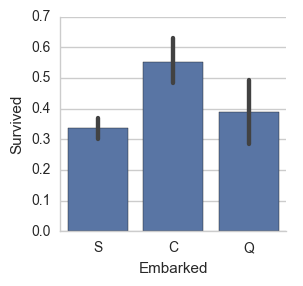

In [20]:
# Investigating correlation between Survivors, class and location of departure and potential ties to royalty

# Visualizing social status bias in survival
plot_categories(titanic_df, cat = 'Embarked', target = 'Survived')


   Survived  Pclass                                               Name  \
0         0       3                            Braund, Mr. Owen Harris   
1         1       1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2         1       3                             Heikkinen, Miss. Laina   
3         1       1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4         0       3                           Allen, Mr. William Henry   

      Sex   Age  SibSp  Parch     Fare Cabin Embarked  
0    male  22.0      1      0   7.2500   NaN        S  
1  female  38.0      1      0  71.2833   C85        C  
2  female  26.0      0      0   7.9250   NaN        S  
3  female  35.0      1      0  53.1000  C123        S  
4    male  35.0      0      0   8.0500   NaN        S  


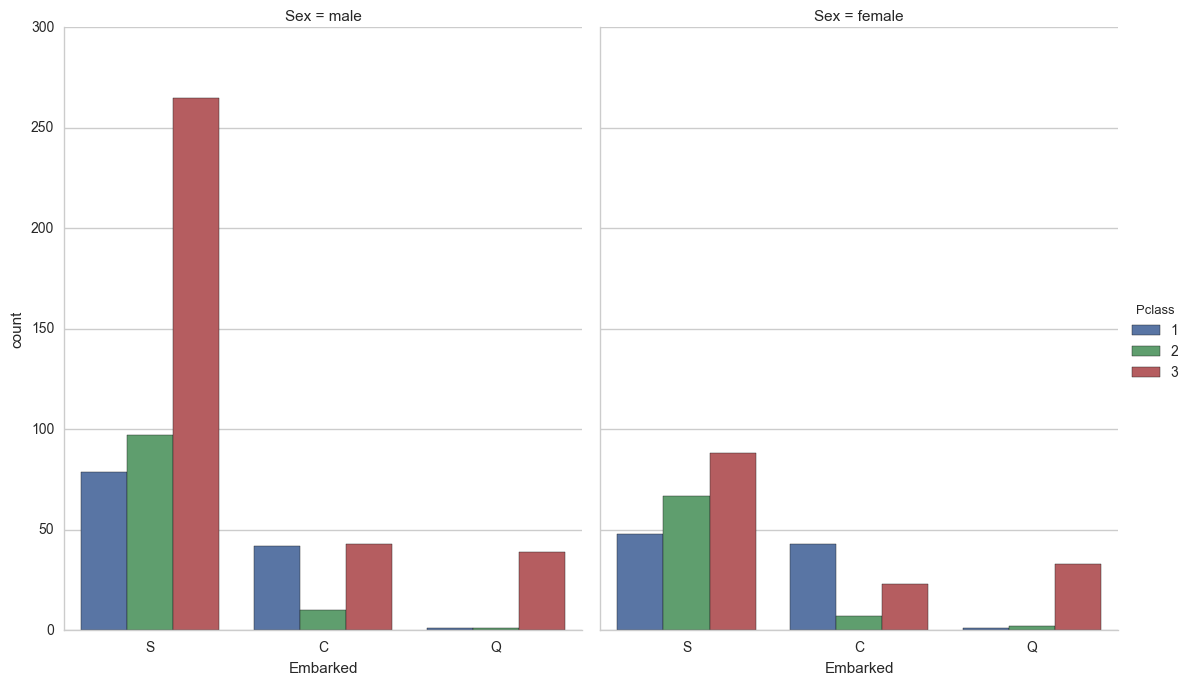

In [21]:
embarked_info = titanic_df.drop(['Ticket','PassengerId'], axis=1)
print embarked_info.head()
graph_count_plotter(embarked_info,'Embarked','Sex','Pclass')


<p>From the information displayed above shows the total number of passengers of each class and gender from each port. We can see that most of the passengers were from the Southhampton(S) port of departure. A great majority of them were from the working class (3). A significant number of Upper and middle class passengers were from this region as well. Now let's see how many lived to tell the tale.</p>

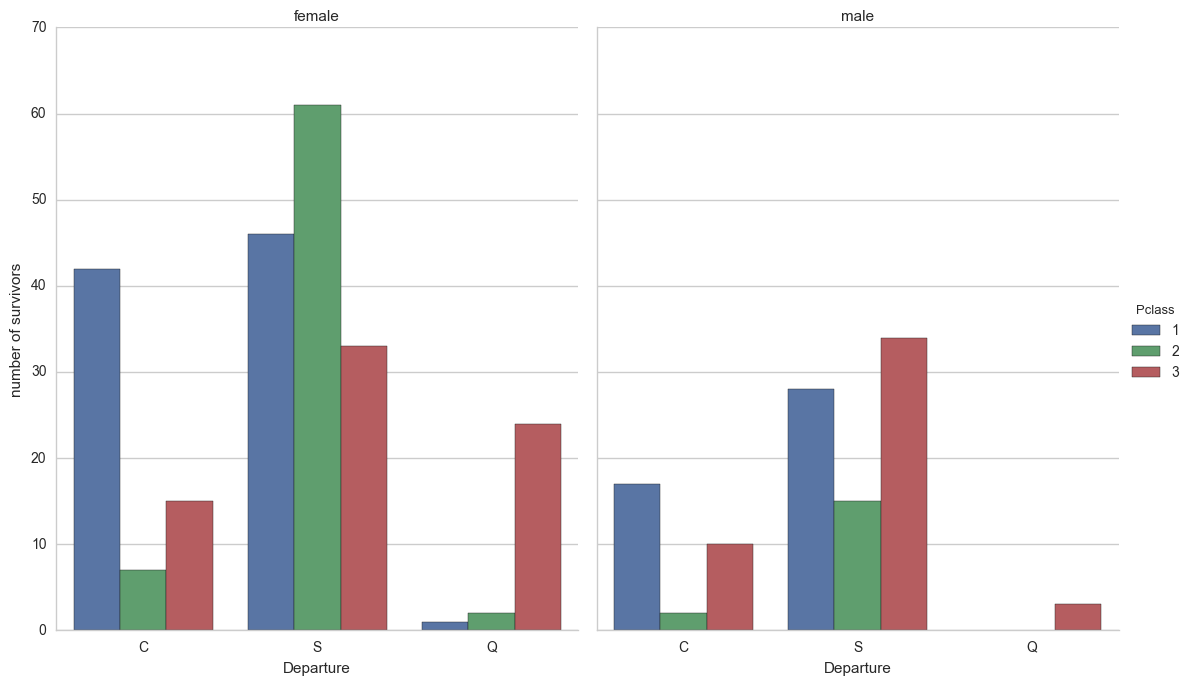

In [22]:
embarked_survivors = embarked_info[embarked_info['Survived']==True]
g = graph_count_plotter(embarked_survivors, 'Embarked', 'Sex', 'Pclass')
(g.set_axis_labels('Departure', 'number of survivors')
     .set_titles('{col_name}'))

<p>The details in the graph above describes the number of survivors with respect to their class and port of departure. It reconfirms our data that the survivors were mostly female and from the upper class(1) to middle class(2) coming from Cherbourg (C)and Southampton (S) and the worker class(3) survivors were primarily from Southampton (S) and Queenstown (Q). This could be attributed to the fact that majority of the passengers were from S. </p>
<p>
It appears that there may not be much significance in this finding since a majority of the passengers were from Southampton survival based on port of departure could be due to pure luck. However, further investigation could be done to study the relation between the cabin number and position of life boats to determine likelihood of survival. 

<h1>Conclusion</h1>
<p>
In the given scenario, my findings in this workbook suggests that if you were female, and of a higher status in society you would have had a higher chance of survival as compared to being from the working class. 
</p>